In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
    array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
from Bio import pairwise2
from Bio import SeqIO
from Bio.pairwise2 import format_alignment
import os
from Bio.SeqUtils import seq1, seq3
import copy
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import nglview

/Users/kaushikb/opt/anaconda3/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [4]:
def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1
 dsspH[dsspH=='E']=0
 dsspH[dsspH=='C']=0
 dsspH[dsspH=='NA']=0
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1)
 SE_H=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspH[:,i].astype(float)
     if(np.mean(data)>0):
      SE_H[i]=[np.mean(data),(block(data))**.5]

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1)
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)
 SE_E=np.zeros((len(dssp[0]),2))

 for i in range(0,len(dssp[0])):
     data=dsspE[:,i].astype(float)
     if(np.mean(data)>0):
      SE_E[i]=[np.mean(data),(block(data))**.5]
 return SE_H, SE_E

In [5]:
def block(x):
    d = log2(len(x))
    if (d - floor(d) != 0):
        x = x[:2**int(floor(d))]
    d = int(floor(d))
    n = 2**d
    s, gamma = zeros(d), zeros(d)
    mu = mean(x)
    for i in arange(0,d):
        n = len(x)
        gamma[i] = (n)**(-1)*sum( (x[0:(n-1)]-mu)*(x[1:n]-mu) )
        s[i] = var(x)
        x = 0.5*(x[0::2] + x[1::2])

    M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]
    q =array([6.634897,  9.210340,  11.344867, 13.276704, 15.086272,
              16.811894, 18.475307, 20.090235, 21.665994, 23.209251,
              24.724970, 26.216967, 27.688250, 29.141238, 30.577914,
              31.999927, 33.408664, 34.805306, 36.190869, 37.566235,
              38.932173, 40.289360, 41.638398, 42.979820, 44.314105,
              45.641683, 46.962942, 48.278236, 49.587884, 50.892181])
    for k in arange(0,d):
        if(M[k] < q[k]):
            break
    if (k >= d-1):
        print("Warning: Use more data")

    return (s[k]/2**(d-k))

In [6]:
def calc_phipsi(trj):
 indices_phi, phis = md.compute_phi(trj)
 indices_psi, psis = md.compute_psi(trj)
 phi_label=[]
 for i_phi in range(0, indices_phi.shape[0]):
      resindex=trj.topology.atom(indices_phi[i_phi][2]).residue.resSeq
      phi_label.append(resindex)
 phi_label=np.array(phi_label)
 #print(phi_label)
 psi_label=[]
 for i_psi in range(0, indices_psi.shape[0]):
      resindex=trj.topology.atom(indices_psi[i_psi][2]).residue.resSeq
      psi_label.append(resindex)
 psi_label=np.array(psi_label)
 #print(psi_label)
 phipsi=[]
 for i in range(0,len(phi_label)-1):
  current_phipsi=np.column_stack((phis[:,i+1],psis[:,i]))
  phipsi.append(current_phipsi)
 phipsi_array=np.array(phipsi)
 return(phipsi_array,psi_label,phi_label)

In [7]:
parm_file = '/Users/kaushikb/Desktop/OXA24/oxa24wt-nowater.parm7'
trajectory = '/Users/kaushikb/Desktop/OXA24/oxa24wt-nowater-Prodlong.nc'
weight_file = '/Users/kaushikb/Desktop/OXA24/output/weights/single_data/N/weights_final.dat'
weights = np.loadtxt(weight_file)
outdir = '/Users/kaushikb/Desktop/OXA24/output/ensemble_compare/'
if not os.path.exists(outdir):
    os.makedirs(outdir)


# print("outdir",outdir)
# print("pdb",pdb)
# print("trajectory",trajectory)
# print("weights_file",weight_file)

In [8]:
pdb = md.load_prmtop(parm_file)

In [63]:
view = nglview.show_file(parm_file)

In [9]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
trj = trj[1:]

top = trj.topology
top = top.subset(top.select("protein"))
trj = trj.atom_slice(trj.top.select('resid <= 243'))
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [10]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
prot_top=top.subset(top.select('protein'))
prot_res=[]
for res in prot_top.residues: prot_res.append(res.resSeq)
prot_resname=(' %s' % [residue.name for residue in prot_top.residues])
residues=len(set(prot_res))

In [11]:
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of protein residues: %d\n" % len(set(prot_res)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 3899

Number of residues: 244

Number of protein residues: 244

Number of frames: 34629

Starting frame: 0

Last frame: 34629

sequence:  [HIS0, ILE1, SER2, SER3, GLN4, GLN5, HIS6, GLU7, LYS8, ALA9, ILE10, LYS11, SER12, TYR13, PHE14, ASP15, GLU16, ALA17, GLN18, THR19, GLN20, GLY21, VAL22, ILE23, ILE24, ILE25, LYS26, GLU27, GLY28, LYS29, ASN30, LEU31, SER32, THR33, TYR34, GLY35, ASN36, ALA37, LEU38, ALA39, ARG40, ALA41, ASN42, LYS43, GLU44, TYR45, VAL46, PRO47, ALA48, SER49, THR50, PHE51, LYS52, MET53, LEU54, ASN55, ALA56, LEU57, ILE58, GLY59, LEU60, GLU61, ASN62, HIS63, LYS64, ALA65, THR66, THR67, ASN68, GLU69, ILE70, PHE71, LYS72, TRP73, ASP74, GLY75, LYS76, LYS77, ARG78, THR79, TYR80, PRO81, MET82, TRP83, GLU84, LYS85, ASP86, MET87, THR88, LEU89, GLY90, GLU91, ALA92, MET93, ALA94, LEU95, SER96, ALA97, VAL98, PRO99, VAL100, TYR101, GLN102, GLU103, LEU104, ALA105, ARG106, ARG107, THR108, GLY109, LEU110, GLU111, LEU112, MET113, GLN114, LYS115, GLU116,

In [12]:
residue_offset=0
prot_res_renum=np.asarray(prot_res)+residue_offset
residue_number = range(0,residues)
residue_number_offsetres = range(residue_offset, residue_offset+residues)
print("Residue Number Range:",residue_number)

Residue Number Range: range(0, 244)


In [13]:
dssp=md.compute_dssp(trj, simplified=True)
np.savetxt(outdir+"/dssp.out",dssp,fmt='%s')
H1_H,H1_E=dssp_convert(dssp)

/var/folders/yc/yv0526ns7wd5r003v79z9c080000gn/T/ipykernel_16718/1329944918.py:15: RuntimeWarning: invalid value encountered in true_divide
  M = (cumsum( ((gamma/s)**2*2**arange(1,d+1)[::-1])[::-1] )  )[::-1]


In [14]:
dsspH=np.copy(dssp)
dsspH[dsspH=='H']=1
dsspH[dsspH=='E']=0
dsspH[dsspH=='C']=0
dsspH[dsspH=='NA']=0
dsspH=dsspH.astype(int)
np.savetxt(outdir+"/dssp.H.dat",dsspH,fmt='%i')
np.savetxt(outdir+"/Hprop.dat",np.column_stack((prot_res_renum,H1_H)),fmt="%.3f")

In [15]:
dsspE=np.copy(dssp)
dsspE[dsspE=='H']=0
dsspE[dsspE=='E']=1
dsspE[dsspE=='C']=0
dsspE[dsspE=='NA']=0
dsspE=dsspE.astype(int)
np.savetxt(outdir+"/dssp.E.dat",dsspE,fmt='%i')
np.savetxt(outdir+"/Eprop.dat",np.column_stack((prot_res_renum,H1_E)),fmt="%.3f")

In [16]:
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 3.0

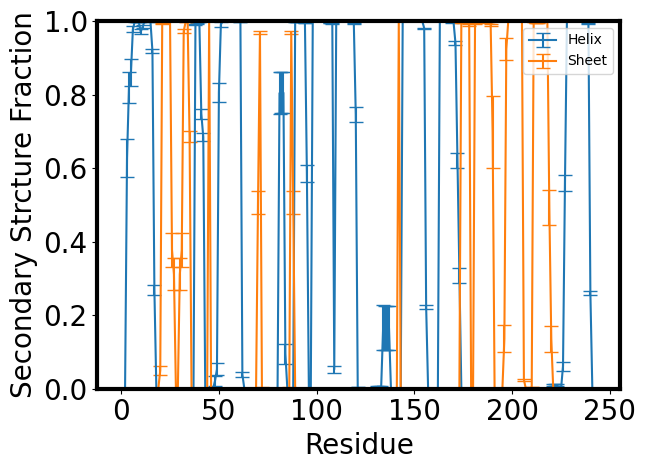

In [17]:
plt.clf()
plt.errorbar(prot_res_renum,H1_H[:,0],yerr=H1_H[:,1], capsize=5,label='Helix')
plt.errorbar(prot_res_renum,H1_E[:,0],yerr=H1_E[:,1], capsize=5,label='Sheet')
plt.ylim(0,1.0)
plt.legend()
plt.xlabel('Residue', size=20)
plt.ylabel('Secondary Strcture Fraction', size=20)
plt.tick_params(labelsize=20)
plt.tight_layout()
plt.savefig(outdir+'/SS.pdf')

In [18]:
Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspH)
Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE)

reweight_Hprop=[]
reweight_Eprop=[]
for i in range(0,len(Hprop)):
    reweight_Hprop.append(np.dot(dsspH[:,i],weights))
    reweight_Eprop.append(np.dot(dsspE[:,i],weights))

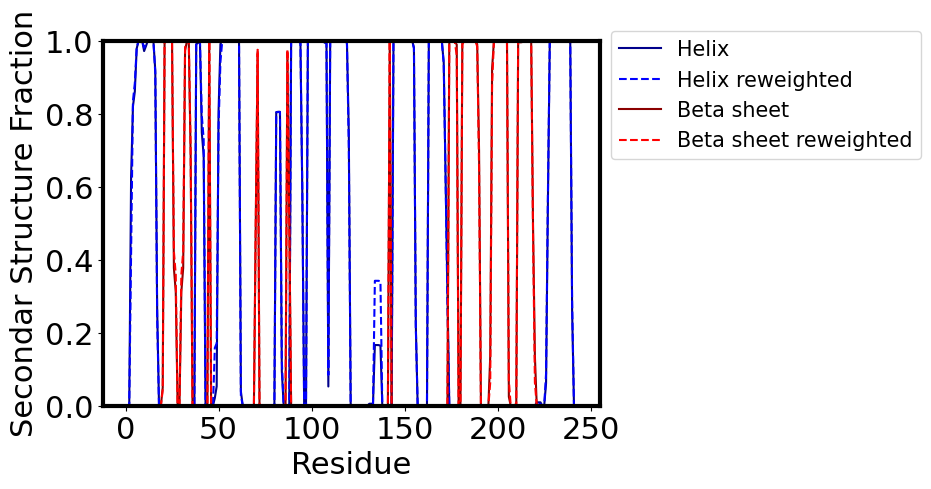

In [19]:
plt.plot(prot_res_renum,Hprop,color='darkblue', label='Helix')
plt.ylim(0,1.0)
plt.plot(prot_res_renum,reweight_Hprop,color='blue',linestyle='dashed', label='Helix reweighted')
plt.plot(prot_res_renum,Eprop,color='darkred', label='Beta sheet')
plt.plot(prot_res_renum,reweight_Eprop,color='red',linestyle='dashed', label='Beta sheet reweighted')
plt.xlabel('Residue', size=22)
plt.ylabel('Secondar Structure Fraction', size=22)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.tight_layout()
plt.legend(loc='center left', bbox_to_anchor= (1.0, 0.85), fontsize=15)
plt.savefig('%s/SS.reweight.pdf'%outdir, bbox_inches='tight')

In [20]:
def calc_Rg(trj):
 mass=[]
 for at in trj.topology.atoms:
    mass.append(at.element.mass)
 mass_CA = len(mass)*[0.0]
 for i in trj.topology.select("name CA"): mass_CA[i]=1.0
 rg_CA=md.compute_rg(trj, masses=np.array(mass_CA))
 return rg_CA

In [21]:
rg=calc_Rg(trj)
np.savetxt(outdir+"/Rg.dat",rg,fmt="%.3f")
print("CA Radius of Gyration All:%6.3lf"%np.average(rg),"+_%6.3lf"%block(rg)**.5)
np.savetxt(outdir+"/Rg.ave.dat",np.column_stack((np.average(rg),block(rg)**.5)),fmt="%.3f")

CA Radius of Gyration All: 1.767 +_ 0.001


In [22]:
block(rg)

7.989785252679463e-07

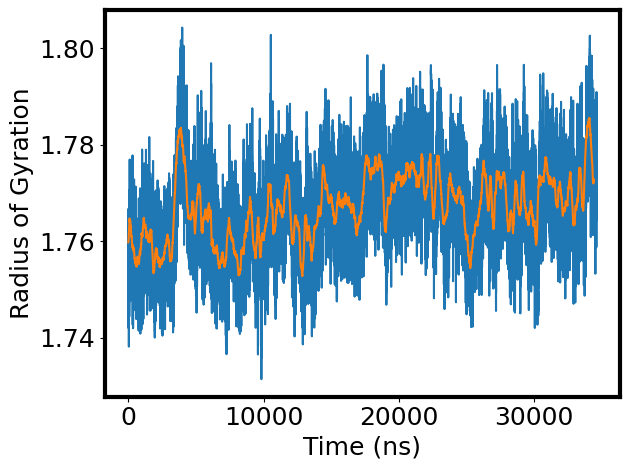

In [23]:
N=200
plt.clf()
plt.plot(rg)
plt.plot(np.convolve(rg,np.ones(N)/N,mode='valid'))
plt.xlabel('Time (ns)', size=18)
plt.ylabel('Radius of Gyration', size=18)
plt.tick_params(labelsize=18)
plt.tight_layout()
plt.savefig(outdir+'/Rg.pdf')

In [24]:
import itertools
def product(x:np.ndarray, y:np.ndarray):
    return np.asarray(list(itertools.product(x, y)))


def combinations(x):
    return np.asarray(list(itertools.combinations(x, 2)))

In [25]:
def residue_distances(traj,
                      index_0: np.ndarray,
                      index_1: np.ndarray = None):
    # intra distance case
    if index_1 is None:
        indices = combinations(index_0)
        return md.compute_contacts(traj, indices)[0], indices

    # inter distance case
    else:
        indices = product(index_0, index_1)
        return md.compute_contacts(traj, indices)[0], indices

In [26]:
distances = np.load('/Users/kaushikb/Desktop/OXA24/distances.npy')

In [27]:
def center(x):
    return x - x.mean(0)


def cov(x: np.ndarray, y: np.ndarray = None,
        weights: np.ndarray = None,
        norm: bool = True, center_: bool = True):

    n = len(x)

    if norm:
        if weights is not None:
            norm = weights.sum()
        else:
            norm = (n - 1)
    else:
        norm = 1

    if y is None:
        y = x

    if center_:
        x, y = map(center, (x, y))

    y = y.reshape(n, -1)

    if weights is not None:
        weights = weights.squeeze()
        # weight for every frame
        if weights.ndim == 1:
            y = (np.diag(weights) @ y).reshape(n, -1)
        # weight matrix
        else:
            assert (weights.shape[0] == weights.shape[1]) and (weights.shape[1] == y.shape[0]), \
                "weights should be a 1D matrix with len == y.shape[0] or a square matrix with shape == (y.shape[0], y.shape[0])"
            y = (weights @ y).reshape(n, -1)

    return x.T @ y / norm

def pca(x: np.ndarray, dim: int = None):
    """compute the business half of econ svd"""
    l, v = np.linalg.eig(cov(x))
    idx = l.argsort()[::-1]
    v = v[..., idx]
    l = l[idx]
    l, v = l[:dim], v[..., :dim]
    projection = center(x) @ v
    return projection, l, v

In [28]:
distances.shape

(34629, 29646)

In [29]:
import dask.array as da
import multiprocessing

In [30]:
def dask_svd(x,
             compressed: bool = False,
             k: int = 2,
             svals=False,
             transposed=False):

    getter = lambda x: x.compute()

    row, col = x.shape

    # this is only going to help if the svd is compressed

    if col > row:
        transposed = True
        x = x.T

    # chunking has to be in one dimension

    chunks = (int((x.shape[0] + 1) / multiprocessing.cpu_count()), x.shape[1])

    x = da.from_array(x,
                      chunks=chunks)

    if svals:
        x = da.linalg.svd_compressed(x, k=k)[1].compute()
        return x

    if compressed:
        x = list(map(getter, da.linalg.svd_compressed(x, k=k)))

    else:
        x = list(map(getter, da.linalg.svd(x)))

    if transposed:
        # to apply the transpose of the product of 3 matrices, need to flip the ordering
        return [i.T for i in x].reverse()
    else:
        return x

In [31]:
distances_mean_free = center(distances)
distances_standard = distances_mean_free/distances_mean_free.std(0)

In [32]:
u,s,vt = dask_svd(distances_mean_free, compressed=True, k=3, svals=False)

In [33]:
proj = distances_mean_free @ vt.T

In [34]:
import pyemma

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:xlabel='PC1', ylabel='PC2'>)

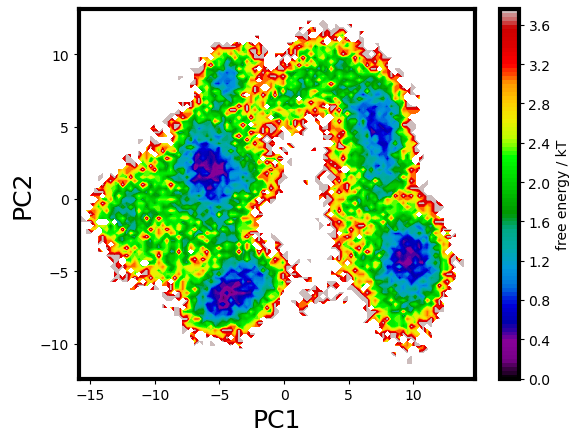

In [35]:
ax = plt.subplot(111)

ax.set_xlabel("PC1", size=18)
ax.set_ylabel("PC2", size=18)
pyemma.plots.plot_free_energy(*proj[:,:2].T, ax=ax)

(<Figure size 640x480 with 2 Axes>, <AxesSubplot:xlabel='PC1', ylabel='PC2'>)

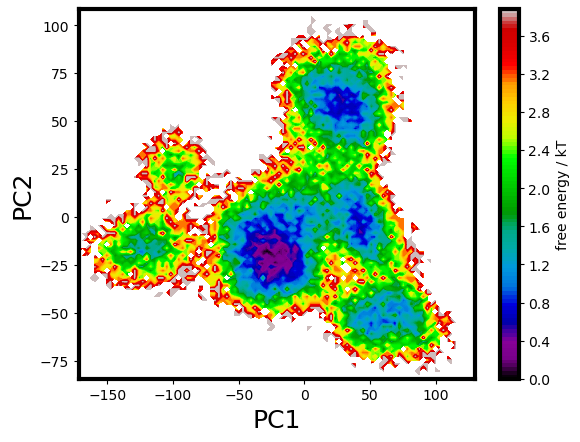

In [36]:
u,s,vt = dask_svd(distances_standard, compressed=True, k=3, svals=False)
proj = distances_standard @ vt.T

ax = plt.subplot(111)
ax.set_xlabel("PC1", size=18)
ax.set_ylabel("PC2", size=18)
pyemma.plots.plot_free_energy(*proj[:,:2].T, ax=ax)